In [1]:
import os
import time

import numpy as np
import pandas as pd
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from ultralytics import YOLO # yolov8

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define model and check

In [3]:
model = YOLO('/model/yolov8x.pt') # Specify model 


image 1/1 c:\Users\My computer\Downloads\School\Personal Education\Github\Artificial-Intelligent-Skills\8. Deep Learning\Computer Vision\Mini Project\Multiple Object Tracking In Real-Time\person.jpg: 384x640 1 person, 2 cups, 1 bowl, 1 dining table, 1 vase, 136.7ms
Speed: 2.5ms preprocess, 136.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to test\person3


Class: cup
Class: dining table
Class: cup
Class: person
Class: vase
Class: bowl


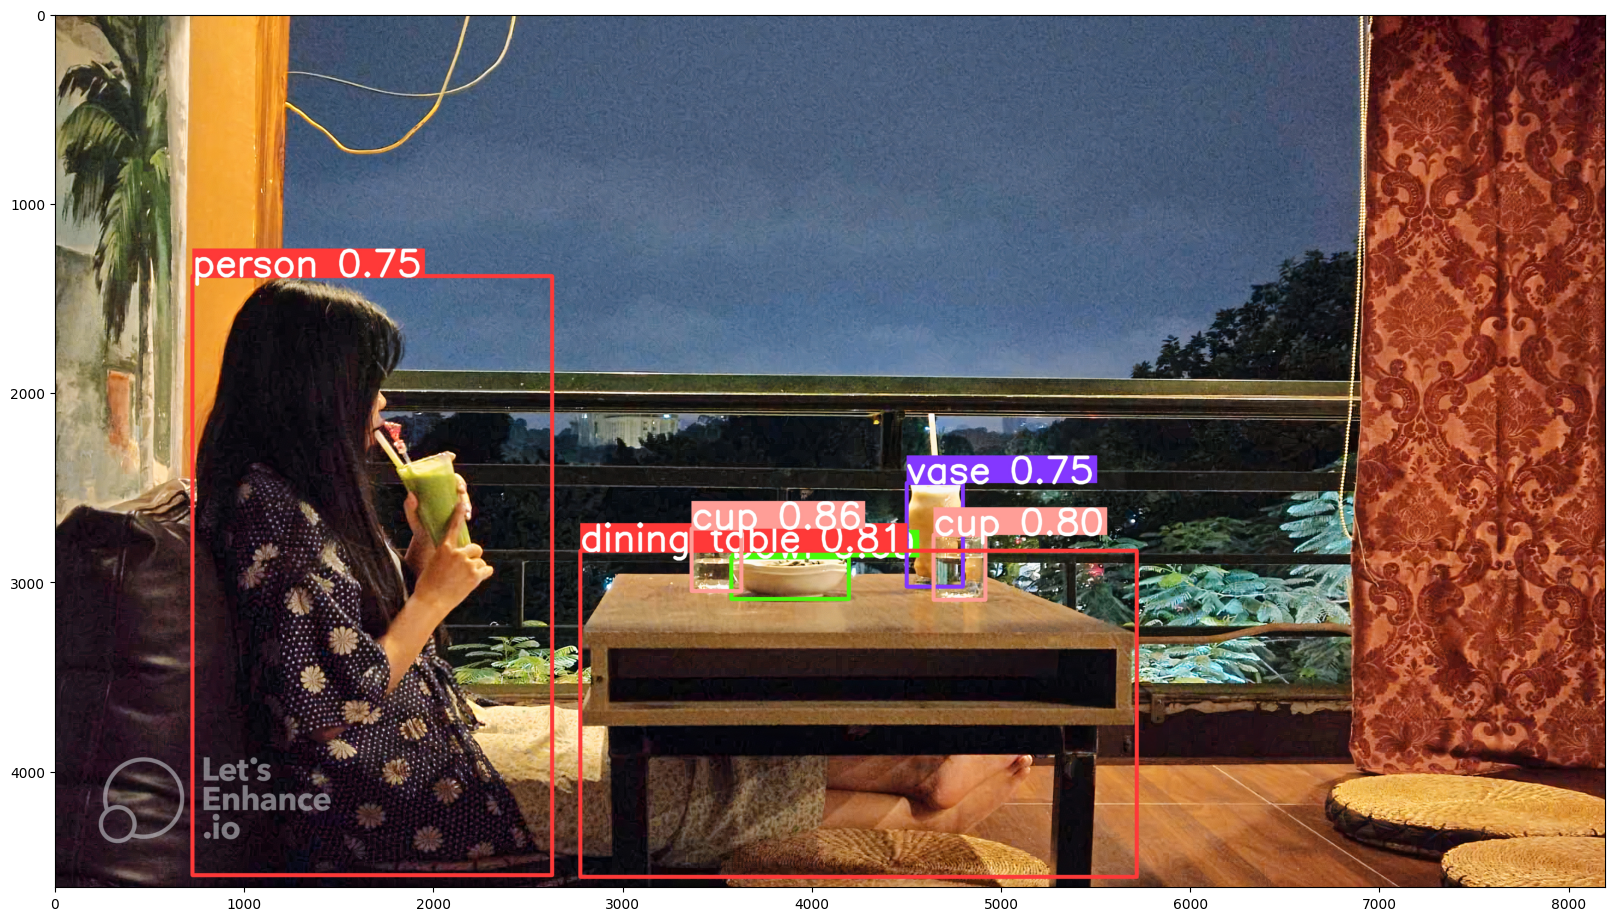

In [4]:
results = model.predict(source=r'person.jpg', project='test', name='attempt', save_conf=True, save=True)

class_names = model.names # Lấy nhãn của model

for result in results:
    boxes = result.boxes  # lấy tọa độ 
    probs = result.probs  # xác suất của các nhãn
    cls = boxes.cls.tolist() 
    xyxy = boxes.xyxy # x1, y1, x2, y2
    xywh = boxes.xywh # x1, y1, w, h
    conf = boxes.conf # Độ tin cậy của nhãn
    for class_index in cls:
        class_name = class_names[int(class_index)]
        print("Class:", class_name)
        
plt.figure(figsize=(20,20))
plt.imshow(Image.open(r"C:\Users\My computer\Downloads\School\Personal Education\Github\Artificial-Intelligent-Skills\8. Deep Learning\Computer Vision\Mini Project\Multiple Object Tracking In Real-Time\test\person\person.jpg"))
plt.show()

# DeepSort

In [4]:
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort
from deep_sort.sort.tracker import Tracker as DeepSortTracker
from deep_sort.sort import nn_matching

deep_weights = 'deep_sort/deep/checkpoint/ckpt.t7' # Weight của deepsort
tracker = DeepSort(model_path = deep_weights, max_age=70, max_iou_distance=0.7, max_dist=0.2, min_confidence=0.3, nms_max_overlap=1.0, use_cuda=True)

In [5]:
def create_new_task_folder(base_path, video_name):
    """
    Create a new task folder with the name of the video under the 'runs' directory.
    :param base_path: The base directory for the 'runs' folder.
    :param video_name: The name of the video file.
    :return: The path to the newly created task folder.
    """
    task_folder = os.path.join(base_path, video_name)
    os.makedirs(task_folder, exist_ok=True)
    return task_folder


In [6]:
def draw_boxes(image, boxes, color=(0, 255, 0), thickness=2):
    '''
    Hàm vẽ các bounding box lên ảnh
    :param image: Ảnh đầu vào
    :param boxes: Các bounding box
    :param color: Màu của bounding box
    :param thickness: Độ dày của bounding box
    :return: Ảnh với các bounding box được vẽ lên
    '''
    
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    return image

In [7]:
def draw_text(image, text, pos, color=(0, 255, 0), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, thickness=2):
    '''
    Hàm vẽ text lên ảnh để đếm số lượng vật thể
    :param image: Ảnh đầu vào
    :param text: Nội dung text
    :param pos: Vị trí của text
    :param color: Màu của text
    :param font: Font của text
    :param font_scale: Font scale của text
    :param thickness: Độ dày của text
    :return: Ảnh với text được vẽ lên
    '''
    cv2.putText(image, text, pos, font, font_scale, color, thickness)
    return image

In [8]:
def frames_to_video(input_path, output_path, fps=30.0):
    '''
    Function to convert multiple frames into a video
    :param input_path: Path to the directory containing the frames
    :param output_path: Path to the directory where the videos will be saved
    :param fps: Frames per second for the output video
    :return: None
    '''
    # Get the list of folders in the input directory
    folders = [f for f in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, f))]

    # Process each folder separately
    for folder in folders:
        folder_path = os.path.join(input_path, folder)
        image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        print(f"Image files in {folder_path}: {image_files}")  # Debugging print statement

        if not image_files:
            print(f"No .jpg files found in {folder_path}")
            continue

        frame = cv2.imread(os.path.join(folder_path, image_files[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(os.path.join(output_path, f"{folder}.mp4"), cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

        for image_file in image_files:
            video.write(cv2.imread(os.path.join(folder_path, image_file)))

        cv2.destroyAllWindows()
        video.release()

In [10]:
def predict(video_path, base_path=os.getcwd()):
    # Get the video name
    video_name = os.path.basename(video_path).split('.')[0]

    # Create a new task folder
    task_folder = create_new_task_folder(base_path, video_name)
    print(f"New task folder: {task_folder}")

    # Initialize tracker
    deep_weights = 'deep_sort\deep\checkpoint\ckpt.t7'
    tracker = DeepSort(model_path=deep_weights, max_age=70, max_iou_distance=0.7, max_dist=0.2, min_confidence=0.3, nms_max_overlap=1.0, use_cuda=True)

    # Initialize variables for FPS calculation and person count
    i = 0
    counter, fps, elapsed = 0, 0, 0
    start_time = time.perf_counter()
    unique_track_ids = set()
    frames = []
    unique_track_ids = set()

    # Initialize a dictionary to store the trails of each object
    trails = {}

    # Process video
    cap = cv2.VideoCapture(video_path)
    
    # Get the video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = task_folder + '\output.mp4'
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            
            og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = og_frame.copy()

            results = model(frame, device=0, classes=0, conf=0.8)
            class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
            
            for result in results:
                boxes = result.boxes  # Boxes object for bbox outputs
                cls = boxes.cls.tolist()  # Convert tensor to list
                xyxy = boxes.xyxy
                conf = boxes.conf
                xywh = boxes.xywh  # box with xywh format, (N, 4)
                for class_index in cls:
                    class_name = class_names[int(class_index)]

            conf = conf.detach().cpu().numpy()
            xyxy = xyxy.detach().cpu().numpy()
            bboxes_xywh = xywh
            bboxes_xywh = xywh.cpu().numpy()
            bboxes_xywh = np.array(bboxes_xywh, dtype=float)
            
            track = tracker.update(bboxes_xywh, conf, og_frame)
            for track in tracker.tracker.tracks:
                track_id = track.track_id
                hits = track.hits
                x1, y1, x2, y2 = track.to_tlbr()  # Get bounding box coordinates in (x1, y1, x2, y2) format
                w = x2 - x1  # Calculate width
                h = y2 - y1  # Calculate height

                # Set color values for red, blue, and green
                red_color = (0, 0, 255)  # (B, G, R)
                blue_color = (255, 0, 0)  # (B, G, R)
                green_color = (0, 255, 0)  # (B, G, R)

                # Determine color based on track_id
                color_id = track_id % 3
                if color_id == 0:
                    color = red_color
                elif color_id == 1:
                    color = blue_color
                else:
                    color = green_color

                cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

                text_color = (0, 0, 0)  # Black color for text
                cv2.putText(og_frame, f"{class_name}-{track_id}", (int(x1) + 10, int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

                # Add the track_id to the set of unique track IDs
                unique_track_ids.add(track_id)

            # Update the person count based on the number of unique track IDs
            person_count = len(unique_track_ids)

            # Update FPS and place on frame
            current_time = time.perf_counter()
            elapsed = (current_time - start_time)
            counter += 1
            if elapsed > 1:
                fps = counter / elapsed
                counter = 0
                start_time = current_time
                
            # Draw person count on frame
            cv2.putText(og_frame, f"Person Count: {person_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Append the frame to the list
            frames.append(og_frame)

            # Write the frame to the output video file
            out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))
        else:
            break

    cap.release()
    out.release()
    print("Ending")

In [11]:
%%time
if __name__ == '__main__':
    # Creating a function to detect and tracking multiple object
    predict(r"C:\Users\My computer\Downloads\School\Personal Education\Github\Artificial-Intelligent-Skills\8. Deep Learning\Computer Vision\Mini Project\Multiple Object Tracking In Real-Time\Short.mp4")

New task folder: c:\Users\My computer\Downloads\School\Personal Education\Github\Artificial-Intelligent-Skills\8. Deep Learning\Computer Vision\Mini Project\Multiple Object Tracking In Real-Time\Short



0: 384x640 1 person, 147.2ms
Speed: 8.0ms preprocess, 147.2ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 40.1ms
Speed: 1.0ms preprocess, 40.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 39.6ms
Speed: 1.0ms preprocess, 39.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 40.8ms
Speed: 1.0ms preprocess, 40.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 40.3ms
Speed: 1.5ms preprocess, 40.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 39.6ms
Speed: 1.5ms preprocess, 39.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 41.1ms
Speed: 2.0ms preprocess, 41.1ms inference, 2.0ms postprocess per image at shape (1, 3,

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
